In [3]:
import os
import random
import cv2
import numpy as np
import pandas as pd
from skimage import measure
import matplotlib.pyplot as plt


def image_read_hsv(image_path):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print("Error: Could not read the image.")
        return None
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    h, w, _ = img_hsv.shape
    crop_x = int(w * 0.20)
    crop_y = int(h * 0.20)
    cropped_hsv = img_hsv[crop_y:h - crop_y, crop_x:w - crop_x]

    return cropped_hsv


def show_image(matrix,x ,windowName):
    padded_matrix = np.array(matrix, dtype=np.uint8) *x
    cv2.imshow(windowName, padded_matrix)
    cv2.waitKey(0)
    cv2.destroyWindow(windowName)


def padded_image(img,padd):
    height, width = img.shape[:2]
    if len(img.shape) == 2:
        padded_matrix = np.ones((height + 2 * padd, width + 2 * padd), dtype=np.uint8) * 0
        padded_matrix[padd:padd + height, padd:padd + width] = img
    else:
        channels = img.shape[2]
        padded_matrix = np.ones((height + 2*padd, width + 2*padd,channels), dtype=np.uint8)*0
        padded_matrix[padd:padd+height, padd:padd+width,:] = img
    return padded_matrix


def cal_histogram(img):
    rows,cols=img.shape[:2]
    arr=np.zeros(256,dtype=int)
    arr1=np.zeros(256,dtype=int)
    arr2=np.zeros(256,dtype=int)
    for i in range(rows):
        for j in range(cols):
            b, g, r=img[i][j]
            arr[b]+=1
            arr1[g] += 1
            arr2[r] += 1

    return arr,arr1,arr2

def plot_graph(data, title, xlabel, ylabel, color):
    plt.figure()
    plt.plot(data, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


def find_root(eq_list, key):
    if key not in eq_list:
        eq_list[key] = key
        return key
    while eq_list[key] != key:
        eq_list[key] = eq_list[eq_list[key]]  # Path compression
        key = eq_list[key]
    return key

def connectivit_8(image,upp_limit,low_limit=0):
    height, width = image.shape[:2]
    connect_8 = np.zeros((height,width), dtype=np.uint16)
    eq_list = {}
    label = 1

    for i in range(1, height):
        for j in range(1, width):
            if image[i, j]>low_limit and image[i,j] <=upp_limit:  # Foreground pixel
                neighbors = []
                if image[i, j - 1]>low_limit and  image[i, j - 1]<=upp_limit:
                    neighbors.append(connect_8[i, j - 1])
                if image[i - 1, j]> low_limit and image[i - 1, j]<=upp_limit:
                    neighbors.append(connect_8[i - 1, j])
                if image[i - 1, j - 1] > low_limit  and image[i - 1, j - 1]<=upp_limit:
                    neighbors.append(connect_8[i - 1, j -1])
                if (j+1)<width and (image[i - 1, j + 1]>low_limit and image[i - 1, j + 1] <=upp_limit):
                    neighbors.append(connect_8[i - 1, j + 1])

                if not neighbors:
                    connect_8[i, j] = label
                    eq_list[label] = label
                    label += 1
                else:
                    min_label = min(neighbors)
                    connect_8[i, j] = min_label
                    for neighbor in neighbors:
                        eq_list[find_root(eq_list, neighbor)] = find_root(eq_list, min_label)

    for i in range(height):
        for j in range(width):
            if connect_8[i, j] > 0:
                connect_8[i, j] = find_root(eq_list, connect_8[i, j])
    """
    unique_labels = set(find_root(eq_list, lbl) for lbl in eq_list.values())
    print("Number of labels:", len(unique_labels))
    print("Equivalence list:", eq_list)
    print(f"Unique Vals: {unique_labels}")
    """
    return connect_8, eq_list


def gauss_filter(size, sigma=1):
    midpoint = size // 2
    val = 0
    frame = np.zeros((size, size), dtype=np.float32)
    for i in range(size):
        for j in range(size):
            x = i - midpoint
            y = j - midpoint
            temp = 1 / (2 * np.pi * sigma ** 2)
            frame[i][j] = (temp * np.exp(-((x ** 2 + y ** 2) / (2 * (sigma ** 2)))))
            val += frame[i][j]
    return frame / val

def apply_gauss(image, size=5, sigma=1):
    frame = gauss_filter(size, sigma)
    rows, cols = image.shape
    output_img = np.zeros((rows, cols), dtype=np.uint8)
    padd_size = size // 2
    padd_img = padded_image(image, padd_size)
    pix_min = np.min(image)
    pix_max = np.max(image)
    for i in range(padd_size, rows + padd_size):
        for j in range(padd_size, cols + padd_size):
            patch= padd_img[i - padd_size:i + padd_size + 1, j - padd_size:j + padd_size + 1]
            new_value=np.sum(np.multiply(patch,frame))
            if pix_max != pix_min:
                normalized_value = int(255 * (new_value - pix_min) / (pix_max - pix_min))
                output_img[i - padd_size, j - padd_size] = normalized_value
            else:
                output_img[i - padd_size, j - padd_size] = int(new_value)
    return output_img


def color_img(img,x):
    rows,cols=img.shape
    matrix = np.array(img, dtype=np.uint8)
    totalPixels=0
    for i in range(0,rows):
        for j in range (0,cols):
            if img[i][j]>0 :
                matrix[i][j]=x
                totalPixels +=1
            else:
                matrix[i][j]=0
    return totalPixels,matrix

def extract_additional_features(mask, gray_img, h, v):
    props = measure.regionprops(mask.astype(int))
    if len(props) == 0:
        return [0] * 7  # 7 features returned now

    prop = props[0]

    # Shape features
    solidity = prop.solidity
    circularity = (4 * np.pi * prop.area) / (prop.perimeter ** 2) if prop.perimeter > 0 else 0

    # Color stats (for valid pixels)
    hue_std = np.std(h)
    value_mean = np.mean(v)
    value_std = np.std(v)

    # Local texture estimate using local variance
    masked_gray = gray_img[mask > 0]
    local_variance = np.var(masked_gray) if len(masked_gray) > 0 else 0

    # Lobes estimation (number of contours)
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_lobes = len(contours)

    return [
        hue_std, value_mean, value_std,
        solidity, circularity,
        num_lobes, local_variance
    ]


In [35]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops


def image_read1(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Could not read the image.")
        return
    return  img
def image_read(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Could not read the image.")
        return

    h, w, _ = img.shape
    crop_x = int(w * 0.15)
    crop_y = int(h * 0.15)

    cropped_img = img[crop_y:h - crop_y, crop_x:w - crop_x]
    return cropped_img

def image_read_grayscale(image_path):
    img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not read the image.")
        return
    return  img


def image_read_hsv(image_path):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print("Error: Could not read the image.")
        return None

    # Convert to HSV
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    h, w, _ = img_hsv.shape
    crop_x = int(w * 0.21)
    crop_y = int(h * 0.21)
    cropped_hsv = img_hsv[crop_y:h - crop_y, crop_x:w - crop_x]

    return cropped_hsv


def show_image(matrix,x ,windowName):
    padded_matrix = np.array(matrix, dtype=np.uint8) *x
    print('padded matrix: ', padded_matrix.shape)

    cv2.imshow(windowName, padded_matrix)
    cv2.waitKey(0)
    cv2.destroyWindow(windowName)


def padded_image(img,padd):
    height, width = img.shape[:2]
    if len(img.shape) == 2:
        padded_matrix = np.ones((height + 2 * padd, width + 2 * padd), dtype=np.uint8) * 0
        padded_matrix[padd:padd + height, padd:padd + width] = img
    else:
        channels = img.shape[2]
        padded_matrix = np.ones((height + 2*padd, width + 2*padd,channels), dtype=np.uint8)*0
        padded_matrix[padd:padd+height, padd:padd+width,:] = img
    return padded_matrix


def cal_histogram(img):
    rows,cols=img.shape[:2]
    arr=np.zeros(256,dtype=int)
    arr1=np.zeros(256,dtype=int)
    arr2=np.zeros(256,dtype=int)
    for i in range(rows):
        for j in range(cols):
            b, g, r=img[i][j]
            arr[b]+=1
            arr1[g] += 1
            arr2[r] += 1

    return arr,arr1,arr2

def plot_graph(data, title, xlabel, ylabel, color):
    plt.figure()
    plt.plot(data, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


def find_root(eq_list, key):
    if key not in eq_list:
        eq_list[key] = key
        return key
    while eq_list[key] != key:
        eq_list[key] = eq_list[eq_list[key]]  # Path compression
        key = eq_list[key]
    return key

def connectivit_8(image,upp_limit,low_limit=0):
    height, width = image.shape[:2]
    connect_8 = np.zeros((height,width), dtype=np.uint16)
    eq_list = {}
    label = 1

    for i in range(1, height):
        for j in range(1, width):
            if image[i, j]>low_limit and image[i,j] <=upp_limit:  # Foreground pixel
                neighbors = []
                if image[i, j - 1]>low_limit and  image[i, j - 1]<=upp_limit:
                    neighbors.append(connect_8[i, j - 1])
                if image[i - 1, j]> low_limit and image[i - 1, j]<=upp_limit:
                    neighbors.append(connect_8[i - 1, j])
                if image[i - 1, j - 1] > low_limit  and image[i - 1, j - 1]<=upp_limit:
                    neighbors.append(connect_8[i - 1, j -1])
                if (j+1)<width and (image[i - 1, j + 1]>low_limit and image[i - 1, j + 1] <=upp_limit):
                    neighbors.append(connect_8[i - 1, j + 1])

                if not neighbors:
                    connect_8[i, j] = label
                    eq_list[label] = label
                    label += 1
                else:
                    min_label = min(neighbors)
                    connect_8[i, j] = min_label
                    for neighbor in neighbors:
                        eq_list[find_root(eq_list, neighbor)] = find_root(eq_list, min_label)

    for i in range(height):
        for j in range(width):
            if connect_8[i, j] > 0:
                connect_8[i, j] = find_root(eq_list, connect_8[i, j])
    """
    unique_labels = set(find_root(eq_list, lbl) for lbl in eq_list.values())
    print("Number of labels:", len(unique_labels))
    print("Equivalence list:", eq_list)
    print(f"Unique Vals: {unique_labels}")
    """
    return connect_8, eq_list


def gauss_filter(size, sigma=1):
    midpoint = size // 2
    val = 0
    frame = np.zeros((size, size), dtype=np.float32)
    for i in range(size):
        for j in range(size):
            x = i - midpoint
            y = j - midpoint
            temp = 1 / (2 * np.pi * sigma ** 2)
            frame[i][j] = (temp * np.exp(-((x ** 2 + y ** 2) / (2 * (sigma ** 2)))))
            val += frame[i][j]
    return frame / val

def apply_gauss(image, size=5, sigma=1):
    frame = gauss_filter(size, sigma)
    rows, cols = image.shape
    output_img = np.zeros((rows, cols), dtype=np.uint8)
    padd_size = size // 2
    padd_img = padded_image(image, padd_size)
    pix_min = np.min(image)
    pix_max = np.max(image)
    for i in range(padd_size, rows + padd_size):
        for j in range(padd_size, cols + padd_size):
            patch= padd_img[i - padd_size:i + padd_size + 1, j - padd_size:j + padd_size + 1]
            new_value=np.sum(np.multiply(patch,frame))
            if pix_max != pix_min:
                normalized_value = int(255 * (new_value - pix_min) / (pix_max - pix_min))
                output_img[i - padd_size, j - padd_size] = normalized_value
            else:
                output_img[i - padd_size, j - padd_size] = int(new_value)
    return output_img


def thresholding(mag_matrix,max_val):
    upperlimit=0.7*max_val
    lowerlimit=0.2*max_val
    rows, cols = mag_matrix.shape[:2]
    matrix = np.zeros((rows,cols), dtype=np.uint8)
    for i in range(0, rows):
        for j in range(0, cols):
            if mag_matrix[i][j] >= upperlimit:
                matrix[i][j] = 1
            elif mag_matrix[i][j] <= lowerlimit:
                matrix[i][j] = 0
            else:
                matrix[i][j]=mag_matrix[i][j]
    return matrix

def color_img(img,x):
    rows,cols=img.shape
    matrix = np.array(img, dtype=np.uint8)
    for i in range(0,rows):
        for j in range (0,cols):
            if img[i][j]>0 :
                matrix[i][j]=x
            else:
                matrix[i][j]=0
    return matrix

def get_region_props(mask):
    labeled = label(mask)  # use 'label' instead of 'sk_label'
    props = regionprops(labeled)
    if props:
        area = props[0].area
        perimeter = props[0].perimeter
        eccentricity = props[0].eccentricity
    else:
        area, perimeter, eccentricity = 0, 0, 0
    return area, perimeter, eccentricity

def get_mean_saturation(s_channel, mask):
    return np.mean(s_channel[mask == 255]) if np.any(mask == 255) else 0

def get_lbp_mean(gray_img, mask, P=8, R=1):
    try:
        lbp = local_binary_pattern(gray_img, P, R, method="uniform")
        return np.mean(lbp[mask == 255]) if np.any(mask == 255) else 0
    except:
        return 0

# Initialize an empty DataFrame
df_all = pd.DataFrame(columns=["x", "y", "H", "S", "V", "label"])

# Dictionary of image folders and labels
wbc_classes = {
    "Basophil": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Basophil",
    "Eosinophil": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Eosinophil",
    "Lymphocyte": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Lymphocyte",
    "Monocyte": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Monocyte",
    "Neutrophil": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Neutrophil"
}



In [4]:

wbc_classes = {
    "Basophil": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Basophil",
    "Eosinophil": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Eosinophil",
    "Lymphocyte": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Lymphocyte",
    "Monocyte": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Monocyte",
    "Neutrophil": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Neutrophil"
}
df_all = pd.DataFrame()
image_id = 0

for class_label, image_dir in wbc_classes.items():
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    selected_images = random.sample(image_files, min(100, len(image_files)))

    for file in selected_images:
        image_path = os.path.join(image_dir, file)
        img_hsv = image_read_hsv(image_path)

        if img_hsv is None:
            continue

        h, s, v = cv2.split(img_hsv)
        img_blur = cv2.medianBlur(s, 7)
        img_gauss = apply_gauss(img_blur, 3, 0.2)
        nuc_img, _ = connectivit_8(img_gauss, 255, 140)
        final_mask = color_img(nuc_img, 255)
        show_image(final_mask,1,"Final Mask")
        ys, xs = np.where(final_mask == 255)


        hsv_values = img_hsv[ys, xs]
        gray_img = cv2.cvtColor(cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR), cv2.COLOR_BGR2GRAY)

        (
            hue_std, value_mean, value_std,
            solidity, circularity,
            num_lobes, local_variance
        ) = extract_additional_features(final_mask, gray_img, hsv_values[:, 0], hsv_values[:, 2])

        data = {
            "label": [class_label],
            "hue_std": [hue_std],
            "value_mean": [value_mean],
            "value_std": [value_std],
            "solidity": [solidity],
            "circularity": [circularity],
            "num_lobes": [num_lobes],
            "local_variance": [local_variance],
            "image_id": [image_id]
        }

        df_image = pd.DataFrame(data)
        df_all = pd.concat([df_all, df_image], ignore_index=True)
        image_id += 1


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [6]:
df_all = pd.DataFrame()
image_id = 0

for class_label, image_dir in wbc_classes.items():
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    selected_images = random.sample(image_files, min(100, len(image_files)))

    for file in selected_images:
        image_path = os.path.join(image_dir, file)
        img_hsv = image_read_hsv(image_path)

        if img_hsv is None:
            continue

        h, s, v = cv2.split(img_hsv)
        img_blur = cv2.medianBlur(s, 7)
        img_gauss = apply_gauss(img_blur, 3, 0.2)
        nuc_img, _ = connectivit_8(img_gauss, 255, 140)
        final_mask = color_img(nuc_img, 255)

        ys, xs = np.where(final_mask == 255)
        if len(xs) == 0:
            continue

        hsv_values = img_hsv[ys, xs]
        gray_img = cv2.cvtColor(cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR), cv2.COLOR_BGR2GRAY)

        area, perimeter, eccentricity = get_region_props(final_mask)
        mean_saturation = get_mean_saturation(s, final_mask)
        lbp_mean = get_lbp_mean(gray_img, final_mask)

        data = {
            "x": xs,
            "y": ys,
            "H": hsv_values[:, 0],
            "S": hsv_values[:, 1],
            "V": hsv_values[:, 2],
            "label": [class_label] * len(xs),
            "image_id": [image_id] * len(xs),
            "area": [area] * len(xs),
            "perimeter": [perimeter] * len(xs),
            "eccentricity": [eccentricity] * len(xs),
            "mean_saturation": [mean_saturation] * len(xs),
            "lbp_mean": [lbp_mean] * len(xs)
        }

        df_image = pd.DataFrame(data)
        df_all = pd.concat([df_all, df_image], ignore_index=True)
        image_id += 1

print(df_all.tail())

            x    y    H    S    V       label  image_id    area  perimeter  \
12496082  123  267  145  145  127  Neutrophil       497  5131.0  317.07821   
12496083  124  267  145  141  130  Neutrophil       497  5131.0  317.07821   
12496084  119  268  147  141  114  Neutrophil       497  5131.0  317.07821   
12496085  120  268  145  143  121  Neutrophil       497  5131.0  317.07821   
12496086  121  268  145  143  123  Neutrophil       497  5131.0  317.07821   

          eccentricity  mean_saturation  lbp_mean  
12496082      0.912759       203.751429   5.59149  
12496083      0.912759       203.751429   5.59149  
12496084      0.912759       203.751429   5.59149  
12496085      0.912759       203.751429   5.59149  
12496086      0.912759       203.751429   5.59149  


In [7]:
df_all.head()

,x,y,H,S,V,label,image_id,area,perimeter,eccentricity,mean_saturation,lbp_mean
0,170,33,136,118,110,Basophil,0,37431.0,1072.856998,0.504732,153.579252,5.263471
1,171,33,136,112,109,Basophil,0,37431.0,1072.856998,0.504732,153.579252,5.263471
2,172,33,136,115,113,Basophil,0,37431.0,1072.856998,0.504732,153.579252,5.263471
3,173,33,136,112,109,Basophil,0,37431.0,1072.856998,0.504732,153.579252,5.263471
4,174,33,136,118,110,Basophil,0,37431.0,1072.856998,0.504732,153.579252,5.263471


In [13]:
# Group by image_id and aggregate all columns
grouped_df = df_all.groupby('image_id').agg({
    'x': 'mean',
    'y': 'mean',
    'H': 'mean',
    'S': 'mean',
    'V': 'mean',
    "area": 'mean',
    "perimeter": 'mean',
    "eccentricity": 'mean',
    "mean_saturation": 'mean',
    "lbp_mean": 'mean',
    'label': 'first'     # assumes consistent label
}).reset_index()

# Add pixel count
grouped_df['pixel_count'] = df_all.groupby('image_id').size().values

# Display
grouped_df.tail()


,image_id,x,y,H,S,V,area,perimeter,eccentricity,mean_saturation,lbp_mean,label,pixel_count
493,493,162.745295,168.051159,142.179783,205.762881,118.995785,13761.0,776.565584,0.697463,205.762881,5.321634,Neutrophil,13761
494,494,164.766983,151.240622,154.595312,211.158050,106.001249,17286.0,667.796031,0.597794,211.158050,5.451280,Neutrophil,17621
495,495,165.919107,164.841312,149.709730,219.308927,107.844973,83.0,34.142136,0.808756,219.308927,5.294002,Neutrophil,14204
496,496,176.948459,186.517260,144.604077,200.750463,120.528584,3201.0,214.752309,0.599955,200.750463,5.218310,Neutrophil,14571
497,497,165.213153,177.846426,142.923625,203.751429,87.942071,5131.0,317.078210,0.912759,203.751429,5.591490,Neutrophil,16969


In [14]:
grouped_df.shape

(498, 13)

In [15]:
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

# Columns to check for outliers
cols_to_check = ['H', 'S', 'V', 'pixel_count',"area","perimeter", "eccentricity", "mean_saturation", "lbp_mean"]

# Remove outliers
grouped_df_filtered = remove_outliers_iqr(grouped_df, cols_to_check)

print(grouped_df_filtered.shape)
# Show result
grouped_df_filtered.tail()


(411, 13)


,image_id,x,y,H,S,V,area,perimeter,eccentricity,mean_saturation,lbp_mean,label,pixel_count
493,493,162.745295,168.051159,142.179783,205.762881,118.995785,13761.0,776.565584,0.697463,205.762881,5.321634,Neutrophil,13761
494,494,164.766983,151.240622,154.595312,211.158050,106.001249,17286.0,667.796031,0.597794,211.158050,5.451280,Neutrophil,17621
495,495,165.919107,164.841312,149.709730,219.308927,107.844973,83.0,34.142136,0.808756,219.308927,5.294002,Neutrophil,14204
496,496,176.948459,186.517260,144.604077,200.750463,120.528584,3201.0,214.752309,0.599955,200.750463,5.218310,Neutrophil,14571
497,497,165.213153,177.846426,142.923625,203.751429,87.942071,5131.0,317.078210,0.912759,203.751429,5.591490,Neutrophil,16969


In [17]:
mean_hsv_train = grouped_df_filtered.groupby('label')[['H', 'S', 'V', 'pixel_count', "area","perimeter", "eccentricity", "mean_saturation", "lbp_mean"]].mean().reset_index()
print(mean_hsv_train.shape)
print(mean_hsv_train.head())

(5, 10)
        label           H           S           V   pixel_count          area  \
0    Basophil  145.659837  177.489024  130.684036  39240.217391  29199.478261   
1  Eosinophil  153.903537  196.746969  134.575656  20451.979592  16067.602041   
2  Lymphocyte  149.463219  202.225906  119.699849  18654.545455  18617.313131   
3    Monocyte  155.319590  187.039898  143.372462  29760.819149  29619.010638   
4  Neutrophil  145.782875  206.573728  111.916719  15366.711340  11052.845361   

    perimeter  eccentricity  mean_saturation  lbp_mean  
0  858.739687      0.629233       177.489024  5.143237  
1  602.268294      0.760660       196.746969  5.526333  
2  526.230001      0.576275       202.225906  5.651642  
3  819.345348      0.697553       187.039898  5.434540  
4  583.032291      0.766320       206.573728  5.328235  


For Test Data

In [ ]:
wbc_classes_test = {
    "Basophil": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Test\Basophil",
    "Eosinophil": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Test\Eosinophil",
    "Lymphocyte": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Test\Lymphocyte",
    "Monocyte": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Test\Monocyte",
    "Neutrophil": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Test\Neutrophil"
}
df_all_test = pd.DataFrame()
image_id = 0

for class_label, image_dir in wbc_classes_test.items():
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    selected_images = random.sample(image_files, min(100, len(image_files)))

    for file in selected_images:
        image_path = os.path.join(image_dir, file)
        img_hsv = image_read_hsv(image_path)

        if img_hsv is None:
            continue

        h, s, v = cv2.split(img_hsv)
        img_blur = cv2.medianBlur(s, 7)
        img_gauss = apply_gauss(img_blur, 3, 0.2)
        nuc_img, _ = connectivit_8(img_gauss, 255, 140)
        final_mask = color_img(nuc_img, 255)

        ys, xs = np.where(final_mask == 255)
        if len(xs) == 0:
            continue

        hsv_values = img_hsv[ys, xs]
        gray_img = cv2.cvtColor(cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR), cv2.COLOR_BGR2GRAY)

        area, perimeter, eccentricity = get_region_props(final_mask)
        mean_saturation = get_mean_saturation(s, final_mask)
        lbp_mean = get_lbp_mean(gray_img, final_mask)

        data = {
            "x": xs,
            "y": ys,
            "H": hsv_values[:, 0],
            "S": hsv_values[:, 1],
            "V": hsv_values[:, 2],
            "label": [class_label] * len(xs),
            "image_id": [image_id] * len(xs),
            "area": [area] * len(xs),
            "perimeter": [perimeter] * len(xs),
            "eccentricity": [eccentricity] * len(xs),
            "mean_saturation": [mean_saturation] * len(xs),
            "lbp_mean": [lbp_mean] * len(xs)
        }

        df_image = pd.DataFrame(data)
        df_all_test = pd.concat([df_all_test, df_image], ignore_index=True)
        image_id += 1



In [21]:
df_all_test.shape

(6348239, 12)

In [22]:
df_all_test.head()

,x,y,H,S,V,label,image_id,area,perimeter,eccentricity,mean_saturation,lbp_mean
0,190,38,152,105,138,Basophil,0,52965.0,1157.827561,0.642224,145.175852,5.164467
1,194,38,150,104,135,Basophil,0,52965.0,1157.827561,0.642224,145.175852,5.164467
2,195,38,150,108,130,Basophil,0,52965.0,1157.827561,0.642224,145.175852,5.164467
3,196,38,150,114,123,Basophil,0,52965.0,1157.827561,0.642224,145.175852,5.164467
4,197,38,150,129,109,Basophil,0,52965.0,1157.827561,0.642224,145.175852,5.164467


In [24]:
# Group by image_id and aggregate all columns
grouped_df_test = df_all_test.groupby('image_id').agg({
    'x': 'mean',
    'y': 'mean',
    'H': 'mean',
    'S': 'mean',
    'V': 'mean',
    "area": 'mean',
    "perimeter": 'mean',
    "eccentricity": 'mean',
    "mean_saturation": 'mean',
    "lbp_mean": 'mean',
    'label': 'first'     # assumes consistent label
}).reset_index()

# Add pixel count
grouped_df_test['pixel_count'] = df_all_test.groupby('image_id').size().values
print(grouped_df_test.shape)
# Display
grouped_df_test.tail()


(249, 13)


,image_id,x,y,H,S,V,area,perimeter,eccentricity,mean_saturation,lbp_mean,label,pixel_count
244,244,170.612479,178.281726,145.545078,202.418094,113.877004,12789.0,586.700577,0.761090,202.418094,5.296896,Neutrophil,12789
245,245,162.672795,167.289962,154.518569,203.064926,139.668908,12422.0,604.499567,0.907443,203.064926,5.413721,Neutrophil,19037
246,246,171.069414,180.426734,146.486030,209.322747,106.584054,14922.0,729.595021,0.596966,209.322747,5.492864,Neutrophil,14925
247,247,170.747985,168.121428,138.447824,220.643265,104.958449,7108.0,436.818326,0.914899,220.643265,5.290341,Neutrophil,13646
248,248,167.117082,174.376913,141.858623,214.371354,105.915380,7503.0,383.646753,0.845877,214.371354,5.631803,Neutrophil,14571


In [32]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import euclidean

# Step 1: Feature vectors for each class
class_vectors = grouped_df_filtered.groupby('label')[['H', 'S', 'V', 'pixel_count',"area","perimeter", "eccentricity", "mean_saturation", "lbp_mean"]].mean()

# Step 2: Group test images
test_features = df_all_test.groupby('image_id').agg({
    'H': 'mean',
    'S': 'mean',
    'V': 'mean',
    'x': 'count',
    "area": 'mean',
    "perimeter": 'mean',
    "eccentricity": 'mean',
    "mean_saturation": 'mean',
    "lbp_mean": 'mean',
    'label': 'first'
}).reset_index()
test_features.rename(columns={'x': 'pixel_count'}, inplace=True)

# Step 3: Predict label for each test image
def predict_label(row):
    input_vector = row[['H', 'S', 'V', 'pixel_count', "area","perimeter", "eccentricity", "mean_saturation", "lbp_mean"]].values
    distances = class_vectors.apply(lambda x: euclidean(input_vector, x), axis=1)
    return distances.idxmin()

test_features['predicted'] = test_features.apply(predict_label, axis=1)

# Step 4: Accuracy
accuracy = accuracy_score(test_features['label'], test_features['predicted'])

# Step 5: Result DataFrame and Accuracy
result_df = test_features[['image_id', 'label', 'predicted']]
print("Accuracy:", accuracy)
result_df.head()


Accuracy: 0.6224899598393574


,image_id,label,predicted
0,0,Basophil,Basophil
1,1,Basophil,Eosinophil
2,2,Basophil,Basophil
3,3,Basophil,Basophil
4,4,Basophil,Basophil


In [27]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Step 1: Prepare training features
X_train = grouped_df_filtered.groupby('label')[['H', 'S', 'V', 'pixel_count', 'area', 'perimeter', 'eccentricity', 'mean_saturation', 'lbp_mean']].mean().reset_index()

# Step 2: Encode labels
le = LabelEncoder()
X_train['encoded_label'] = le.fit_transform(X_train['label'])

# Step 3: Prepare test features
test_features = df_all_test.groupby('image_id').agg({
    'H': 'mean',
    'S': 'mean',
    'V': 'mean',
    'x': 'count',
    'area': 'mean',
    'perimeter': 'mean',
    'eccentricity': 'mean',
    'mean_saturation': 'mean',
    'lbp_mean': 'mean',
    'label': 'first'
}).reset_index()
test_features.rename(columns={'x': 'pixel_count'}, inplace=True)

# Step 4: Encode test labels
test_features['encoded_label'] = le.transform(test_features['label'])

# Step 5: Train SVM
svm = SVC()
svm.fit(X_train.drop(['label', 'encoded_label'], axis=1), X_train['encoded_label'])

# Step 6: Predict
X_test = test_features[['H', 'S', 'V', 'pixel_count', 'area', 'perimeter', 'eccentricity', 'mean_saturation', 'lbp_mean']]
test_features['predicted'] = svm.predict(X_test)

# Step 7: Decode predictions
test_features['predicted_label'] = le.inverse_transform(test_features['predicted'])

# Step 8: Accuracy
accuracy = accuracy_score(test_features['encoded_label'], test_features['predicted'])

# Step 9: Result DataFrame
result_df = test_features[['image_id', 'label', 'predicted_label']]
print("SVM Accuracy:", accuracy)
result_df.head()


SVM Accuracy: 0.6224899598393574


,image_id,label,predicted_label
0,0,Basophil,Basophil
1,1,Basophil,Eosinophil
2,2,Basophil,Basophil
3,3,Basophil,Basophil
4,4,Basophil,Basophil


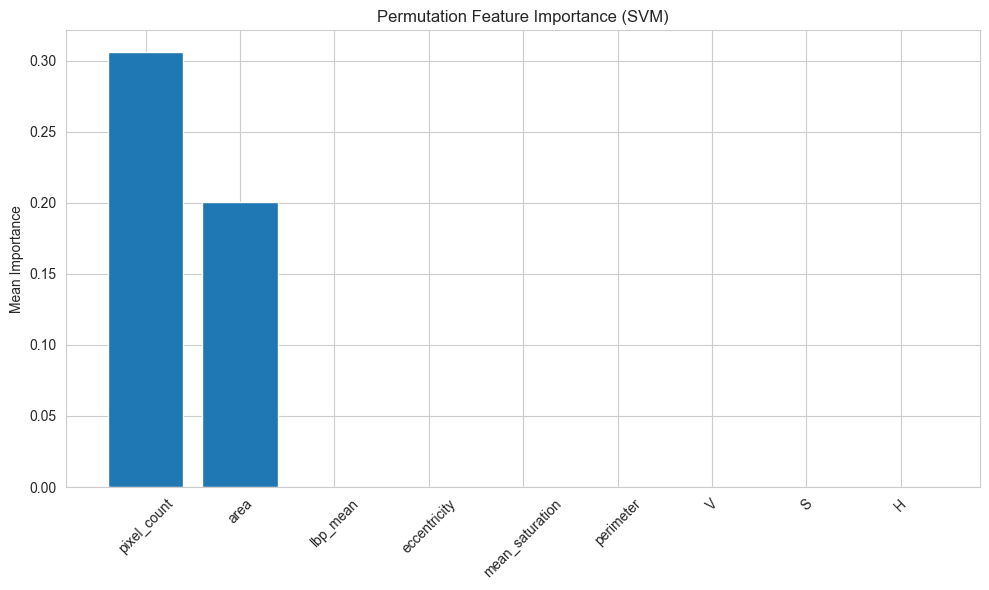

In [28]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Compute permutation importance
result = permutation_importance(svm, X_test, test_features['encoded_label'], n_repeats=10, random_state=42)

# Plotting
feature_names = X_test.columns
importances = result.importances_mean
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Permutation Feature Importance (SVM)")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), feature_names[indices], rotation=45)
plt.ylabel("Mean Importance")
plt.tight_layout()
plt.show()


In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import euclidean

# Step 1: Feature vectors for each class (only area and pixel_count)
class_vectors = grouped_df_filtered.groupby('label')[['pixel_count', 'area']].mean()

# Step 2: Group test images
test_features = df_all_test.groupby('image_id').agg({
    'x': 'count',
    'area': 'mean',
    'label': 'first'
}).reset_index()
test_features.rename(columns={'x': 'pixel_count'}, inplace=True)

# Step 3: Predict label for each test image
def predict_label(row):
    input_vector = row[['pixel_count', 'area']].values
    distances = class_vectors.apply(lambda x: euclidean(input_vector, x), axis=1)
    return distances.idxmin()

test_features['predicted'] = test_features.apply(predict_label, axis=1)

# Step 4: Accuracy
accuracy = accuracy_score(test_features['label'], test_features['predicted'])

# Step 5: Result DataFrame and Accuracy
result_df = test_features[['image_id', 'label', 'predicted']]
print("Accuracy:", accuracy)
result_df.head()


Accuracy: 0.6224899598393574


,image_id,label,predicted
0,0,Basophil,Basophil
1,1,Basophil,Eosinophil
2,2,Basophil,Basophil
3,3,Basophil,Basophil
4,4,Basophil,Basophil
